In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import pandas as pd
import scipy
import math
import sys

%matplotlib inline

/Users/bastienbrunod/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def plot_graph(k, labels, predicted_labels):
    hist = []
    for i in range(k):
        hist.append([])
    
    for i in range(len(labels)):
        hist[labels[i]].append(predicted_labels[i])

    plt.hist(hist)

In [3]:
def iter_kmeans(points, k, epochs=10000, centroids=None):
    not_finished = True
    if centroids is None:
        random_mask = np.random.choice(points.shape[0], k, replace=False)
        centroids = points[random_mask, :]
    epoch = 0
    labels = []
    
    while not_finished and epoch < epochs:
        labels = []

        for point in points:
            shortest_i, shortest_distance = None, 10000000000
            for i, centroid in enumerate(centroids):
                distance = scipy.spatial.distance.euclidean(point, centroid)
                if distance <= shortest_distance:
                    shortest_distance = distance
                    shortest_i = i
            labels.append(shortest_i)

        labels = np.array(labels)
        not_finished = False

        for i in range(k):
            new_centroid = np.mean(points[np.where(labels == i)], axis=0)
            if not np.all(np.isclose(new_centroid, centroids[i])):
                centroids[i] = new_centroid
                not_finished = True

        if epoch != 0 and epoch % (epochs // 10) == 0:
            print(epoch)
        epoch = epoch + 1
        
    return labels, centroids


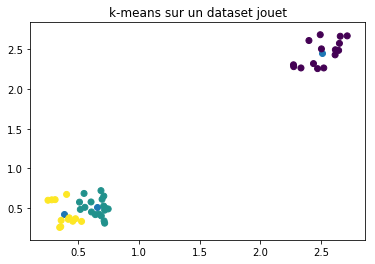

In [7]:
k = 3
points = []
for i in range(k):
    points.extend((np.random.rand(15, 2)) / 2 + (i - 1.5) * (i - 1.5))

points = np.array(points)
labels, centroids = iter_kmeans(points, k)

plt.title("k-means sur un dataset jouet")
plt.scatter(centroids[:, 0], centroids[:, 1])
plt.scatter(points[:, 0], points[:, 1], c=labels)
plt.show()

In [8]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
x_train = x_train.astype('float32') / 255.0
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])
x_test = x_test.astype('float32') / 255.0

In [9]:
mask_0 = np.where(y_train == 0)
mask_1 = np.where(y_train == 1)

In [10]:
sub_x_train = np.concatenate((x_train[mask_0][:500], x_train[mask_1][:500]))
sub_y_train = np.concatenate((y_train[mask_0][:500], y_train[mask_1][:500]))

In [11]:
labels, centroids = iter_kmeans(sub_x_train, 10, epochs=100)

KeyboardInterrupt: 

In [ ]:
plt.title("k-means sur un dataset jouet")
plt.scatter(centroids[:, 0], centroids[:, 1])
plt.scatter(sub_x_train[:, 0], sub_x_train[:, 1], c=labels)
plt.show()

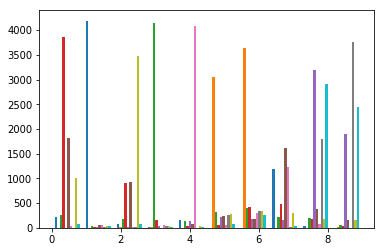

In [115]:
plot_graph(10, y_train, labels.astype('uint8'))

In [70]:
from keras.layers import Input, Dense
from keras.models import Model

In [71]:
x_train.shape

(60000, 784)

In [12]:
encoding_dim = 32  

input_img = Input(shape=(x_train.shape[1],))

encoded = Dense(encoding_dim, activation='relu')(input_img)

decoded = Dense(x_train.shape[1], activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

encoder = Model(input_img, encoded)


encoded_input = Input(shape=(encoding_dim,))

decoder_layer = autoencoder.layers[-1]

decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

NameError: name 'Input' is not defined

In [95]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 28us/step - loss: 0.1040 - acc: 0.8134 - val_loss: 0.1022 - val_acc: 0.8125
Epoch 2/50
60000/60000 [==============================] - 2s 28us/step - loss: 0.1037 - acc: 0.8134 - val_loss: 0.1019 - val_acc: 0.8126
Epoch 3/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.1034 - acc: 0.8134 - val_loss: 0.1016 - val_acc: 0.8126
Epoch 4/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.1031 - acc: 0.8135 - val_loss: 0.1014 - val_acc: 0.8126
Epoch 5/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.1029 - acc: 0.8135 - val_loss: 0.1011 - val_acc: 0.8126
Epoch 6/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.1026 - acc: 0.8135 - val_loss: 0.1009 - val_acc: 0.8127
Epoch 7/50
60000/60000 [==============================] - 2s 28us/step - loss: 0.1024 - acc: 0.8135 - val_loss: 0.1007 - val_acc